# Post-processing CSV

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime


import cv2
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import sys
sys.path.append("../common/")

In [4]:
from data_utils import get_scalers, LABELS, TRAIN_IMAGE_IDS
from image_utils import get_image_data
from submission_utils import submission_iterator, write_shp_from_polygons, write_shp_from_csv, write_shp_from_mask
from submission_utils import get_scaled_polygons, get_polygons, compute_label_image, get_data_csv, get_image_ids
from submission_utils import rewrite_submission
from visu_utils import plt_st, display_img_1b

In [5]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [6]:
CSV_FILE_NEW = "../results/sub_mix_20170304_2329.csv"
# CSV_FILE_NEW = "../results/sub_mix_1_big173_9_small9_8_big38_2_small152_10_small66_7_big127_5_big38_4_small135_3_big81_6_big72_20170305_1626.csv"
# CSV_FILE_NEW = "../results/submission_2017-03-05-23-26.csv"
CSV_FILE_TRAIN = "../results/sub_model_1_20170304_1826_nan.csv"
# CSV_FILE_OLD = "../results/sub_unet_3D_mix_th_80_3_P_M_A_20170218_2057_0.8906966279736366_reduced.csv"


Compare submission's predictions raw and post-processed on trained data with ground truth

In [7]:
from np_metrics import score

Get common image ids from submission file and training image ids

In [8]:
import pandas as pd
import os

In [9]:
df = pd.read_csv(os.path.join('..', 'input', 'sample_submission.csv'))
submission_image_ids = df['ImageId'].unique()

In [10]:
print TRAIN_IMAGE_IDS

['6040_2_2' '6120_2_2' '6120_2_0' '6090_2_0' '6040_1_3' '6040_1_0'
 '6100_1_3' '6010_4_2' '6110_4_0' '6140_3_1' '6110_1_2' '6100_2_3'
 '6150_2_3' '6160_2_1' '6140_1_2' '6110_3_1' '6010_4_4' '6170_2_4'
 '6170_4_1' '6170_0_4' '6060_2_3' '6070_2_3' '6010_1_2' '6040_4_4'
 '6100_2_2']


In [11]:
set(TRAIN_IMAGE_IDS) & set(submission_image_ids)

{'6010_1_2', '6040_4_4', '6070_2_3', '6100_2_2'}

In [12]:
# get_image_ids(CSV_FILE_NEW)

In [13]:
def write_shp_pred_pp(image_id, csv_file):
    data_csv = get_data_csv(image_id, csv_file)
    assert data_csv is not None, "No data_csv"
    write_shp_from_csv("../results/shp/%s_new.shp" % image_id, data_csv)
    polygons = get_scaled_polygons(data_csv)
    y_pred_raw = compute_label_image(image_id, polygons)
    y_pred_pp = mask_postprocessing(y_pred_raw, class_pp_func_list)
    write_shp_from_mask("../results/shp/%s_pp.shp" % image_id, image_id, y_pred_pp)

In [14]:
def compare_true_pred_pp(image_id, csv_file, write_shp=True, visualize_labels=()):
    y_true = get_image_data(image_id, 'label')
    data_csv = get_data_csv(image_id, csv_file)
    assert data_csv is not None, "No data_csv"
    if write_shp:
        write_shp_from_csv("../results/shp/%s_new.shp" % image_id, data_csv)
    polygons = get_scaled_polygons(data_csv)    
    y_pred_raw = compute_label_image(image_id, polygons)
#     y_pred_raw[:,:,2] = 0 
#     y_pred_raw[:,:,4] = 0 
#     y_pred_raw[:,:,5] = 0 
#     y_pred_raw[:,:,6] = 0 
    
    h = min(y_true.shape[0], y_pred_raw.shape[0])
    w = min(y_true.shape[1], y_pred_raw.shape[1])
    s1 = score(y_true[:h,:w,:], y_pred_raw[:h,:w,:])    
    print "True vs Pred Raw: ", s1
    
    polygons = shape_postprocessing(polygons, class_shape_pp_func_list)
    y_pred_pp = compute_label_image(image_id, polygons)
    y_pred_pp = mask_postprocessing(y_pred_pp, class_pp_func_list)
#     y_pred_pp[:,:,2] = 0    
#     y_pred_pp[:,:,4] = 0 
#     y_pred_pp[:,:,5] = 0 
#     y_pred_pp[:,:,6] = 0 
    
    h = min(y_true.shape[0], y_pred_pp.shape[0])
    w = min(y_true.shape[1], y_pred_pp.shape[1])
    s2 = score(y_true[:h,:w,:], y_pred_pp[:h,:w,:])
    print "True vs Pred PP: ", s2
    if write_shp:
        write_shp_from_mask("../results/shp/%s_pp.shp" % image_id, image_id, y_pred_pp)
        
        
        
    if len(visualize_labels) > 0:
        ll = len(visualize_labels)
        for i in visualize_labels:
            if i % 2 == 0:
                plt_st(12, 6)
            plt.subplot(131)
            display_img_1b(y_true[:,:,i])
            plt.title("Truth")
            plt.subplot(132)
            display_img_1b(y_pred_raw[:,:,i])
            plt.title("Raw")
            plt.subplot(133)
            display_img_1b(y_pred_pp[:,:,i])
            plt.title("PP")
        
        
        
    return s1, s2

Single image tests

In [16]:
# image_id = "6110_1_1"
# image_id = "6110_1_0"
image_id = "6120_3_1"
# image_id = "6120_3_2"
data_csv = get_data_csv(image_id, CSV_FILE_NEW)


# image_id = "6120_2_2"
# image_id = "6100_1_3"
# image_id = "6140_3_1"


# image_id="6170_2_4"
# data_csv = get_data_csv(image_id, CSV_FILE_TRAIN)

assert data_csv is not None, "WTF"
polygons = get_scaled_polygons(data_csv)

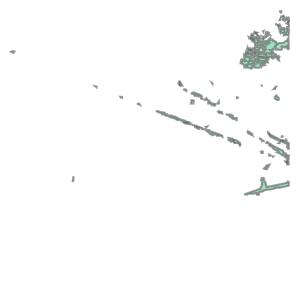

In [17]:
polygons[3]

In [210]:
indices = []
for p in polygons[3]:
    p2 = p.convex_hull
#     indices.append([p.length, p.area, 4.0 * np.pi * p.area / p.length ** 2, p.area/p.length, p2.area/p.area, p.length/p2.length])
    indices.append([p.length, p.area, 4.0 * np.pi * p.area / p.length ** 2, p.area/p.length, p2.area/p.area, p.length/p2.length, p.area/p2.length, p2.area/p.length])
indices = np.array(indices)

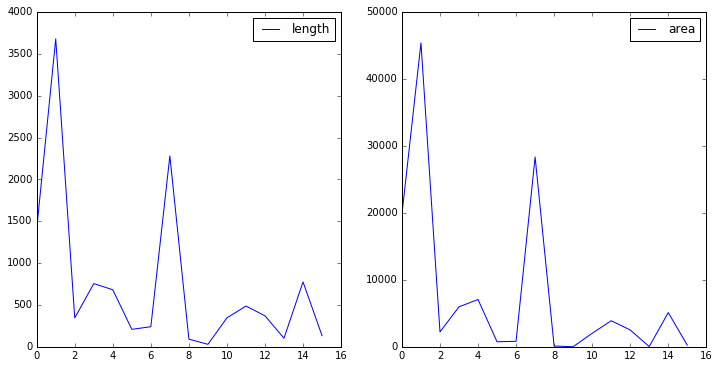

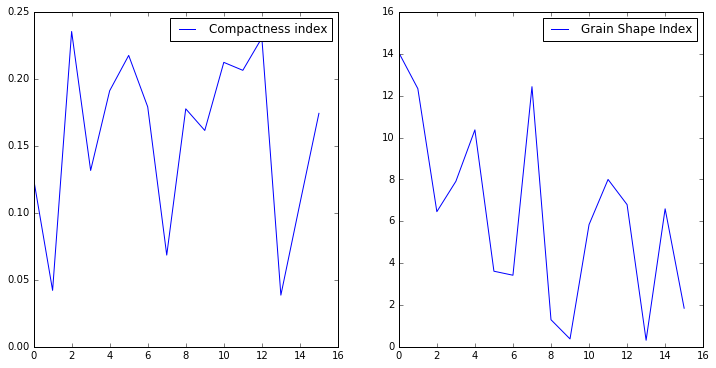

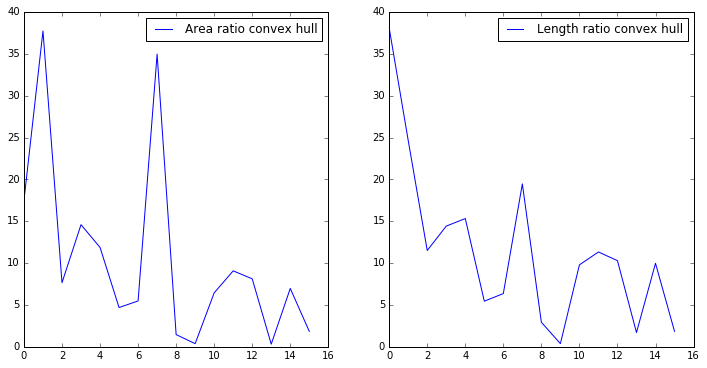

In [211]:
plt_st(12, 6)
plt.subplot(121)
plt.plot(indices[:,0], label='length')
plt.legend()
plt.subplot(122)
plt.plot(indices[:,1], label='area')
plt.legend()

plt_st(12, 6)
plt.subplot(121)
plt.plot(indices[:,2], label='Compactness index')
plt.legend()
plt.subplot(122)
plt.plot(indices[:,3], label='Grain Shape Index')
plt.legend()

plt_st(12, 6)
plt.subplot(121)
plt.plot(indices[:,4], label='Area ratio convex hull')
plt.legend()
plt.subplot(122)
plt.plot(indices[:,5], label='Length ratio convex hull')
plt.legend()

In [212]:
from shapely.geometry import MultiPolygon

In [213]:
def pca(points, n_components=2):
    covar, mean = cv2.calcCovarMatrix(points, None, cv2.COVAR_SCALE | cv2.COVAR_ROWS | cv2.COVAR_SCRAMBLED)
    ret, e_vals, e_vecs = cv2.eigen(covar)
    # Conversion + normalisation required due to 'scrambled' mode
    e_vecs = cv2.gemm(e_vecs, points - mean, 1, None, 0)
    # apply_along_axis() slices 1D rows, but normalize() returns 4x1 vectors
    e_vecs = np.apply_along_axis(lambda n: cv2.normalize(n, None).flat, 1, e_vecs)
    return e_vecs[:n_components,:], e_vals[:n_components,:], mean

2 16


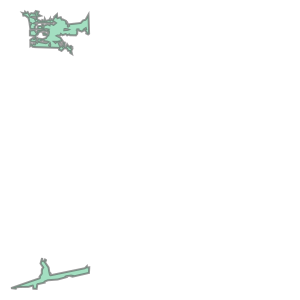

In [214]:
new_polygons = []
for i, _p in enumerate(polygons[3]):
    
    p = _p #.buffer(-5).buffer(5).buffer(25).buffer(-25)
  
    cnvh = p.convex_hull
    v = cnvh.area / p.length
    if 4.0 * np.pi * p.area / p.length ** 2 < 0.45 and v > 20:
        new_polygons.append(p)
#         if False and p.area > 1000: 
#             _, e_vals, _ = pca(np.array(p.exterior.coords))
#             cnvh = p.convex_hull
#             v = p.area / cnvh.length
#             if e_vals[0] > e_vals[1] * 5.0 or p.area/cnvh.area < 0.5:
#                 new_polygons.append(p)
#         else:
#             new_polygons.append(p)

#     p2 = p.convex_hull
#     print i, p2.area, p.area, p2.area/p.area, p2.length / p.length

#     if p2.length / p.length > 0.5:
    #if  p2.area/p.area < 1.5 or p2.area/p.area > 2.5 :
#         print i, p2.area, p.area, p2.area/p.area, p2.length / p.length
#         new_polygons.append(p)

    #if 4.0 * np.pi * p.area / p.length ** 2 < 0.53:
#     p2 = p.convex_hull
#     if p.length / p2.length < 2.75: 
# #         if p2.area / p.area  > 1.5 or :
# #             print i, p2.area, p.area, p2.length / p.length, p2.area / p.area
#         new_polygons.append(p)


        

new_polygons = MultiPolygon(new_polygons)
print len(new_polygons), len(polygons[3])
new_polygons

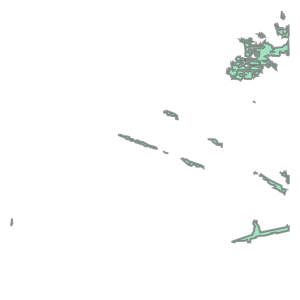

In [215]:
polygons[3]

In [118]:
from postprocessing_utils import sieve

In [21]:
image = compute_label_image(image_id, polygons)
out = crop_postprocessing(image[:,:,6])
#out = sieve(image[:,:,3], compactness=0.25, use_convex_hull=True)

In [22]:
from visu_utils import display_img_1b, plt_st

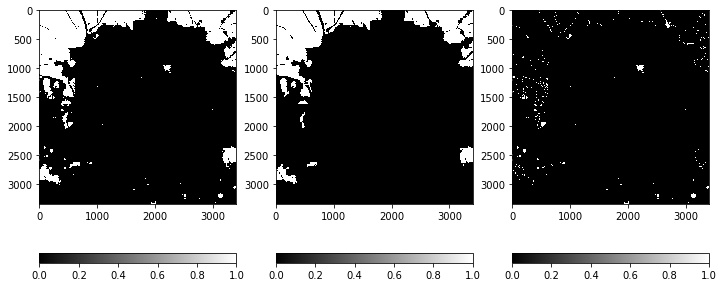

In [25]:
plt_st(12, 6)
plt.subplot(131)
display_img_1b(image[:,:,6])
plt.subplot(132)
display_img_1b(out)
plt.subplot(133)
display_img_1b(image[:,:,6] - out)

In [216]:
from postprocessing_utils import path_postprocessing, crop_postprocessing, mask_postprocessing
from postprocessing_utils import trees_postprocessing, buildings_postprocessing, roads_postprocessing, standing_water_postprocessing
from postprocessing_utils import shape_postprocessing, roads_shape_postprocessing


class_pp_func_list = {
    1: buildings_postprocessing, 
#    3: roads_postprocessing,
    5: trees_postprocessing, 
    8: standing_water_postprocessing, 
    
}

class_shape_pp_func_list = {
    3: roads_shape_postprocessing
}

In [88]:
# image_id = "6110_4_0"
# write_shp_pred_pp(image_id, CSV_FILE_TRAIN)

True vs Pred Raw:  0.220104
True vs Pred PP:  0.219598


(0.22010404, 0.21959823)

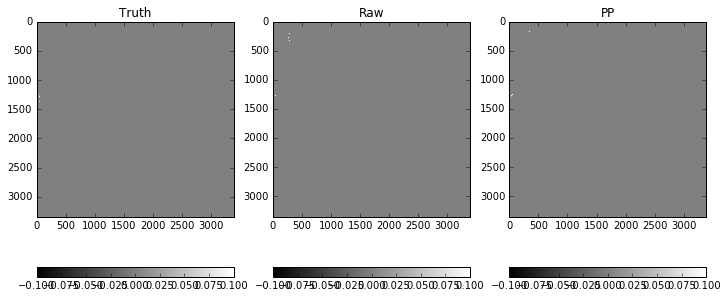

In [105]:
# image_id = "6170_2_4"
# compare_true_pred_pp(image_id, CSV_FILE_TRAIN, write_shp=False, visualize_labels=[8])

Check on all training data:

In [82]:
train_ids = TRAIN_IMAGE_IDS
# train_ids = list(set(TRAIN_IMAGE_IDS) & set(submission_image_ids))

In [109]:
total_s1 = 0
total_s2 = 0
for image_id in train_ids:
    print "--", image_id
    s1, s2 = compare_true_pred_pp(image_id, CSV_FILE_TRAIN, write_shp=False)
    total_s1 += s1
    total_s2 += s2

total_s1 *= 1.0 / len(train_ids)
total_s2 *= 1.0 / len(train_ids)
print "Final score: ", total_s1, total_s2

-- 6040_2_2
True vs Pred Raw:  0.124523
True vs Pred PP:  0.124523
-- 6120_2_2
True vs Pred Raw:  0.301466


KeyboardInterrupt: 

Standing water only

-- 6040_2_2
True vs Pred Raw:  0.124523
True vs Pred PP:  0.124523
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.302711
-- 6120_2_0
True vs Pred Raw:  0.332018
True vs Pred PP:  0.332018
-- 6090_2_0
True vs Pred Raw:  0.14743
True vs Pred PP:  0.155803
-- 6040_1_3
True vs Pred Raw:  0.137345
True vs Pred PP:  0.137345
-- 6040_1_0
True vs Pred Raw:  0.145944
True vs Pred PP:  0.145944
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.352157
-- 6010_4_2
True vs Pred Raw:  0.131629
True vs Pred PP:  0.131629
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.399476
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.338185
-- 6110_1_2
True vs Pred Raw:  0.233097
True vs Pred PP:  0.23354
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.295865
-- 6150_2_3
True vs Pred Raw:  0.2014
True vs Pred PP:  0.2014
-- 6160_2_1
True vs Pred Raw:  0.139019
True vs Pred PP:  0.139019
-- 6140_1_2
True vs Pred Raw:  0.243752
True vs Pred PP:  0.243999
-- 6110_3_1
True vs Pred Raw:  0.355562
True vs Pred PP:  0.358455
-- 6010_4_4
True vs Pred Raw:  0.120205
True vs Pred PP:  0.120205
-- 6170_2_4
True vs Pred Raw:  0.220104
True vs Pred PP:  0.219598
-- 6170_4_1
True vs Pred Raw:  0.117173
True vs Pred PP:  0.117173
-- 6170_0_4
True vs Pred Raw:  0.1282
True vs Pred PP:  0.1282
-- 6060_2_3
True vs Pred Raw:  0.183337
True vs Pred PP:  0.183337
-- 6070_2_3
True vs Pred Raw:  0.213583
True vs Pred PP:  0.212168
-- 6010_1_2
True vs Pred Raw:  0.119722
True vs Pred PP:  0.119722
-- 6040_4_4
True vs Pred Raw:  0.121834
True vs Pred PP:  0.121834
-- 6100_2_2
True vs Pred Raw:  0.256762
True vs Pred PP:  0.256735
Final score:  0.214040441513 0.214841640592

Roads only 

-- 6040_2_2
True vs Pred Raw:  0.124523
True vs Pred PP:  0.124523
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.298926
-- 6120_2_0
True vs Pred Raw:  0.332018
True vs Pred PP:  0.335549
-- 6090_2_0
True vs Pred Raw:  0.14743
True vs Pred PP:  0.14743
-- 6040_1_3
True vs Pred Raw:  0.137345
True vs Pred PP:  0.137345
-- 6040_1_0
True vs Pred Raw:  0.145944
True vs Pred PP:  0.145954
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.359294
-- 6010_4_2
True vs Pred Raw:  0.131629
True vs Pred PP:  0.131629
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.404222
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.338892
-- 6110_1_2
True vs Pred Raw:  0.233097
True vs Pred PP:  0.232702
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.298773
-- 6150_2_3
True vs Pred Raw:  0.2014
True vs Pred PP:  0.2014
-- 6160_2_1
True vs Pred Raw:  0.139019
True vs Pred PP:  0.139025
-- 6140_1_2
True vs Pred Raw:  0.243752
True vs Pred PP:  0.243329
-- 6110_3_1
True vs Pred Raw:  0.355562
True vs Pred PP:  0.360551
-- 6010_4_4
True vs Pred Raw:  0.120205
True vs Pred PP:  0.120216
-- 6170_2_4
True vs Pred Raw:  0.220104
True vs Pred PP:  0.220123
-- 6170_4_1
True vs Pred Raw:  0.117173
True vs Pred PP:  0.117173
-- 6170_0_4
True vs Pred Raw:  0.1282
True vs Pred PP:  0.1282
-- 6060_2_3
True vs Pred Raw:  0.183337
True vs Pred PP:  0.183439
-- 6070_2_3
True vs Pred Raw:  0.213583
True vs Pred PP:  0.215103
-- 6010_1_2
True vs Pred Raw:  0.119722
True vs Pred PP:  0.119722
-- 6040_4_4
True vs Pred Raw:  0.121834
True vs Pred PP:  0.121842
-- 6100_2_2
True vs Pred Raw:  0.256762
True vs Pred PP:  0.263174
Final score:  0.214040441513 0.215541426241


Buildings + Roads + Trees

-- 6040_2_2
True vs Pred Raw:  0.124523
True vs Pred PP:  0.125387
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.300682
-- 6120_2_0
True vs Pred Raw:  0.332018
True vs Pred PP:  0.334135
-- 6090_2_0
True vs Pred Raw:  0.14743
True vs Pred PP:  0.148428
-- 6040_1_3
True vs Pred Raw:  0.137345
True vs Pred PP:  0.137015
-- 6040_1_0
True vs Pred Raw:  0.145944
True vs Pred PP:  0.145777
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.358986
-- 6010_4_2
True vs Pred Raw:  0.131629
True vs Pred PP:  0.132197
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.40738
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.342271
-- 6110_1_2
True vs Pred Raw:  0.233097
True vs Pred PP:  0.236529
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.296382
-- 6150_2_3
True vs Pred Raw:  0.2014
True vs Pred PP:  0.205462
-- 6160_2_1
True vs Pred Raw:  0.139019
True vs Pred PP:  0.142017
-- 6140_1_2
True vs Pred Raw:  0.243752
True vs Pred PP:  0.247979
-- 6110_3_1
True vs Pred Raw:  0.355562
True vs Pred PP:  0.363409
-- 6010_4_4
True vs Pred Raw:  0.120205
True vs Pred PP:  0.120364
-- 6170_2_4
True vs Pred Raw:  0.220104
True vs Pred PP:  0.22293
-- 6170_4_1
True vs Pred Raw:  0.117173
True vs Pred PP:  0.118462
-- 6170_0_4
True vs Pred Raw:  0.1282
True vs Pred PP:  0.128708
-- 6060_2_3
True vs Pred Raw:  0.183337
True vs Pred PP:  0.187098
-- 6070_2_3
True vs Pred Raw:  0.213583
True vs Pred PP:  0.214826
-- 6010_1_2
True vs Pred Raw:  0.119722
True vs Pred PP:  0.120264
-- 6040_4_4
True vs Pred Raw:  0.121834
True vs Pred PP:  0.119407
-- 6100_2_2
True vs Pred Raw:  0.256762
True vs Pred PP:  0.263456
Final score:  0.214040441513 0.216782031655


Buildings + Roads1 + Trees + Water

-- 6040_2_2
True vs Pred Raw:  0.124523
True vs Pred PP:  0.125387
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.301161
-- 6120_2_0
True vs Pred Raw:  0.332018
True vs Pred PP:  0.334135
-- 6090_2_0
True vs Pred Raw:  0.14743
True vs Pred PP:  0.153845
-- 6040_1_3
True vs Pred Raw:  0.137345
True vs Pred PP:  0.137015
-- 6040_1_0
True vs Pred Raw:  0.145944
True vs Pred PP:  0.145777
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.359964
-- 6010_4_2
True vs Pred Raw:  0.131629
True vs Pred PP:  0.132197
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.407909
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.342736
-- 6110_1_2
True vs Pred Raw:  0.233097
True vs Pred PP:  0.237605
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.294984
-- 6150_2_3
True vs Pred Raw:  0.2014
True vs Pred PP:  0.205462
-- 6160_2_1
True vs Pred Raw:  0.139019
True vs Pred PP:  0.142017
-- 6140_1_2
True vs Pred Raw:  0.243752
True vs Pred PP:  0.24867
-- 6110_3_1
True vs Pred Raw:  0.355562
True vs Pred PP:  0.364052
-- 6010_4_4
True vs Pred Raw:  0.120205
True vs Pred PP:  0.120364
-- 6170_2_4
True vs Pred Raw:  0.220104
True vs Pred PP:  0.222433
-- 6170_4_1
True vs Pred Raw:  0.117173
True vs Pred PP:  0.118462
-- 6170_0_4
True vs Pred Raw:  0.1282
True vs Pred PP:  0.128708
-- 6060_2_3
True vs Pred Raw:  0.183337
True vs Pred PP:  0.187098
-- 6070_2_3
True vs Pred Raw:  0.213583
True vs Pred PP:  0.215432
-- 6010_1_2
True vs Pred Raw:  0.119722
True vs Pred PP:  0.120264
-- 6040_4_4
True vs Pred Raw:  0.121834
True vs Pred PP:  0.119407
-- 6100_2_2
True vs Pred Raw:  0.256762
True vs Pred PP:  0.263298
Final score:  0.214040441513 0.217135282755


Buildings + Roads2 + Trees + Water

-- 6040_2_2
True vs Pred Raw:  0.124523
True vs Pred PP:  0.124417
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.300166
-- 6120_2_0
True vs Pred Raw:  0.332018
True vs Pred PP:  0.335998
-- 6090_2_0
True vs Pred Raw:  0.14743
True vs Pred PP:  0.153565
-- 6040_1_3
True vs Pred Raw:  0.137345
True vs Pred PP:  0.136793
-- 6040_1_0
True vs Pred Raw:  0.145944
True vs Pred PP:  0.143905
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.358503
-- 6010_4_2
True vs Pred Raw:  0.131629
True vs Pred PP:  0.132173
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.40677
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.340892
-- 6110_1_2
True vs Pred Raw:  0.233097
True vs Pred PP:  0.236653
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.295633
-- 6150_2_3
True vs Pred Raw:  0.2014
True vs Pred PP:  0.204052
-- 6160_2_1
True vs Pred Raw:  0.139019
True vs Pred PP:  0.139806
-- 6140_1_2
True vs Pred Raw:  0.243752
True vs Pred PP:  0.246801
-- 6110_3_1
True vs Pred Raw:  0.355562
True vs Pred PP:  0.363503
-- 6010_4_4
True vs Pred Raw:  0.120205
True vs Pred PP:  0.120366
-- 6170_2_4
True vs Pred Raw:  0.220104
True vs Pred PP:  0.218792
-- 6170_4_1
True vs Pred Raw:  0.117173
True vs Pred PP:  0.117373
-- 6170_0_4
True vs Pred Raw:  0.1282
True vs Pred PP:  0.12805
-- 6060_2_3
True vs Pred Raw:  0.183337
True vs Pred PP:  0.185607
-- 6070_2_3
True vs Pred Raw:  0.213583
True vs Pred PP:  0.215486
-- 6010_1_2
True vs Pred Raw:  0.119722
True vs Pred PP:  0.120306
-- 6040_4_4
True vs Pred Raw:  0.121834
True vs Pred PP:  0.120122
-- 6100_2_2
True vs Pred Raw:  0.256762
True vs Pred PP:  0.262368
Final score:  0.214040441513 0.216324033737

Save new submission

In [217]:
submission_file = '../results/submission_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
rewrite_submission(CSV_FILE_NEW, submission_file, class_pp_func_list, class_shape_pp_func_list)

IOError: [Errno 2] No such file or directory: '../results/submission_2017-03-06-19-58.csv'

In [113]:
import pandas as pd

In [114]:
df1 = pd.read_csv(CSV_FILE_NEW)
df2 = pd.read_csv(submission_file)

In [115]:
assert (df1['ImageId'] == df2['ImageId']).all(), "WTF"
assert (df1['ClassType'] == df2['ClassType']).all(), "WTF"

In [17]:
# assert (df1['MultipolygonWKT'] == df2['MultipolygonWKT']).all(), "WTF"

In [66]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [74]:
from image_utils import compute_aligned_image, compute_mean_warp_matrix

In [75]:
pair_images = [("6110", "6140"), ("6020", "6130"), ("6030", "6150")]

In [100]:
def merge_pair_images(pair_images, csv_filename, merge_labels=(3, 4, 5, 7)):
    
    n, m = (5, 5)    
    for pair in pair_images:        
        for i in range(n):
            for j in range(m):
                image_id_1 = pair[0] + "_%i_%i" % (i, j)
                image_id_2 = pair[1] + "_%i_%i" % (i, j)        
                print image_id_1, image_id_2
                
                image_3b_1 = get_image_data(image_id_1, '3b')
                image_3b_2 = get_image_data(image_id_2, '3b')
                
                roi_size=(150, 150)                
                warp_matrix_12 = compute_mean_warp_matrix(image_3b_1, image_3b_2, 
                                                          roi_size=roi_size, err=0.001, 
                                                          use_gradients=False)
                tx_12 = warp_matrix_12[0, 2]
                ty_12 = warp_matrix_12[1, 2]
                print " tx_12, ty_12 :", tx_12, ty_12
                data_csv_1 = get_data_csv(image_id_1, csv_filename)
                data_csv_2 = get_data_csv(image_id_2, csv_filename)   
                polygons_1 = get_scaled_polygons(data_csv_1, '3b')    
                polygons_2 = get_scaled_polygons(data_csv_2, '3b')    
                print len(polygons_1), len(polygons_2)
                break
            break
        break
    


In [101]:
submission_file = "../results/submission_2017-03-07-02-17.csv"

6110_0_0 6140_0_0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 tx_12, ty_12 : 0.0 0.0
6 6


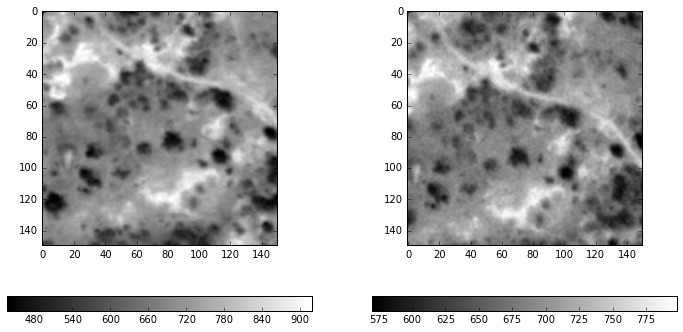

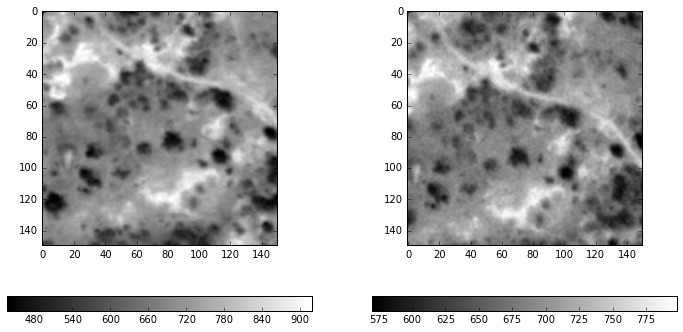

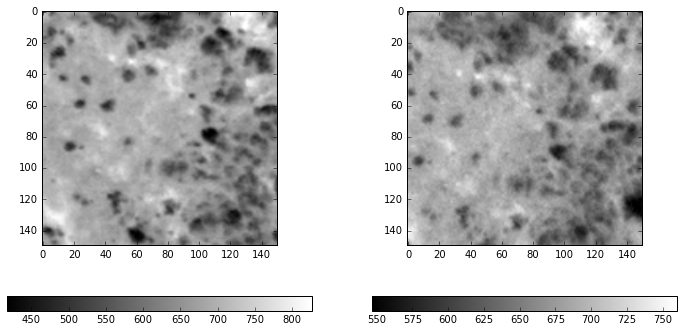

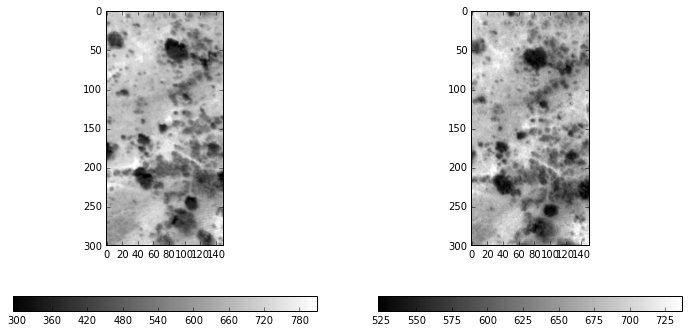

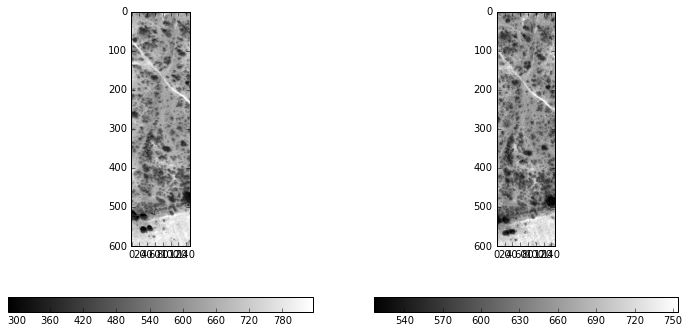

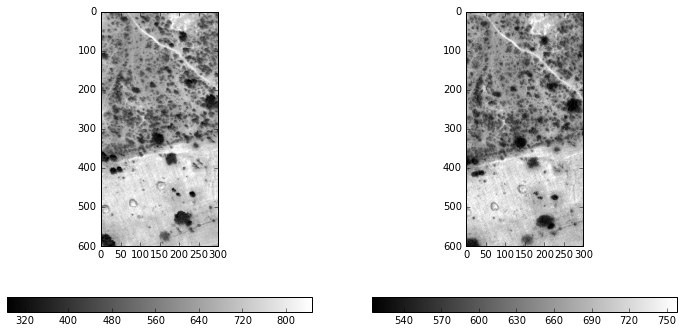

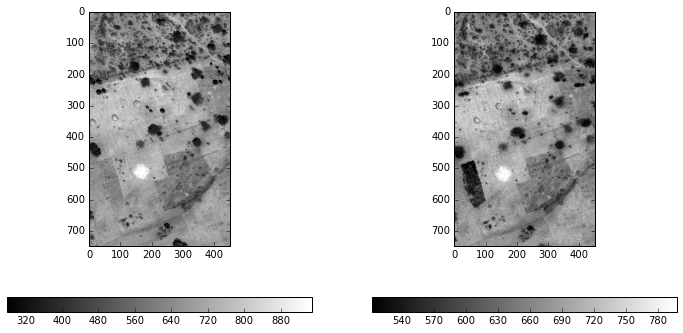

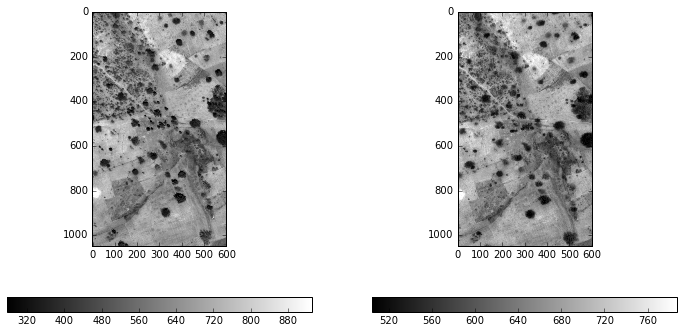

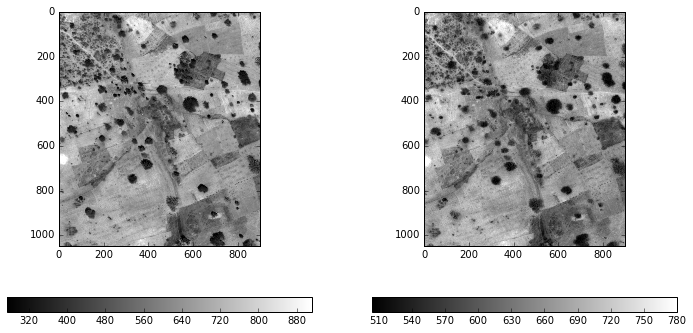

In [102]:
merge_pair_images(pair_images, submission_file)

Find objects on image

In [53]:
from data_utils import ORDERED_LABEL_IDS, get_resized_polygons

for i, v in enumerate(ORDERED_LABEL_IDS):
    print i, v, LABELS[v]
    
image_shape = get_image_data(image_id, '3b', return_shape_only=True)
rpolygons = get_resized_polygons(image_id, *image_shape[:2])

0 0 None
1 6 Crops
2 4 Track
3 3 Road
4 8 Standing water
5 7 Waterway
6 2 Misc. Manmade structures
7 10 Vehicle Small
8 9 Vehicle Large
9 1 Buildings
10 5 Trees


In [55]:
labels = None
label_ids = ORDERED_LABEL_IDS if labels is None else [i for i in ORDERED_LABEL_IDS if i in labels]
for i, class_type in enumerate(label_ids):
    if class_type not in rpolygons:
        continue
    print class_type, LABELS[class_type], len(rpolygons[class_type])
#     for polygon in rpolygons[class_type]:
#         print polygon.centroid

6 Crops 0
4 Track 12
3 Road 0
8 Standing water 0
7 Waterway 0
2 Misc. Manmade structures 44
10 Vehicle Small 0
9 Vehicle Large 0
1 Buildings 0
5 Trees 1733


Visual data analysis

In [116]:
import gdal
from visu_utils import scale_percentile

def generate_complete_image(image_id):
    filename = os.path.join("..", "results", "visu", '%s.tif' % image_id)
    if os.path.exists(filename):
        print "Image is already created. Remove it"
        os.remove(filename)        

    tile_size = (1024, 1024)
    n, m = 5, 5
    complete_image = np.zeros((5*tile_size[0], 5*tile_size[1]), dtype=np.uint16)
    counter = 0
    for i in range(n):
        ys = i*tile_size[1]
        ye = ys + tile_size[1]
        for j in range(m):
            xs = j*tile_size[0]
            xe = xs + tile_size[0]
            _id = image_id + "_%i_%i" % (i, j)
            img = get_image_data(_id, 'pan')
            img = cv2.resize(img, dsize=tile_size)    
            complete_image[ys:ye, xs:xe] = img

    complete_image_8u = scale_percentile(complete_image, 0.1, 99.9)             
    # Initialize output file:
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(filename, complete_image_8u.shape[1], complete_image_8u.shape[0], 1, gdal.GDT_Byte)
    assert dataset is not None, "Failed to create a file"

    band = dataset.GetRasterBand(1)
    band.WriteArray(complete_image_8u, xoff=0, yoff=0)

    dataset = None

In [117]:
from submission_utils import get_data_csv
from shapely.wkt import loads
from shapely.affinity import scale, translate

def get_transformed_polygons(data_csv, x, y, w, h):
    out = {}
    image_id = data_csv[0][0]
    xs, ys = get_scalers(image_id, h, w)
    for poly_info in data_csv:
        if "MULTIPOLYGON" not in poly_info[2][:20]:
            continue
        polygons = loads(poly_info[2])
        new_polygons = scale(polygons, xfact=xs, yfact=ys, origin=(0, 0, 0))        
        new_polygons = translate(new_polygons, xoff=x, yoff=y)
        out[int(poly_info[1])] = new_polygons
    return out

from collections import defaultdict

def generate_complete_shp_from_csv(image_id, csv_filename, suffix=''):
    
    filename = os.path.join("..", "results", "visu", '%s_%s.shp' % (image_id, suffix))
    if os.path.exists(filename):
        print "Image is already created. Remove it"
        os.remove(filename)        
        
    tile_size = (1024, 1024)
    n, m = 5, 5
    all_polygons = defaultdict(list)
    counter = 0
    for i in range(n):
        y = i*tile_size[1]
        for j in range(m):
            x = j*tile_size[0]
            _id = image_id + "_%i_%i" % (i, j)
            print "--", _id
            data_csv = get_data_csv(_id, csv_filename)        
            if data_csv is None:
                continue
            polygons = get_transformed_polygons(data_csv, x, y, tile_size[0], tile_size[1])
            for k in polygons:
                all_polygons[k].append(polygons[k])
    write_shp_from_polygons(filename, image_id, all_polygons)


In [85]:
get_image_ids(CSV_FILE_NEW)

['6120_2_4', '6120_2_3', '6120_2_1']

In [125]:
image_id = "6110"

In [121]:
generate_complete_image(image_id)

AssertionError: Image is not found: id=6120_2_2_0_0, type=pan

In [126]:
# CSV_FILE_NEW = "../results/sub_mix_20170304_2329.csv"
# CSV_FILE_NEW = "../results/sub_mix_1_big173_9_small9_8_big38_2_small152_10_small66_7_big127_5_big38_4_small135_3_big81_6_big72_20170305_1626.csv"
# CSV_FILE_NEW = "../results/sub_mix_8_big38_10_small66_6_big72_3_big81_5_big38_9_small9_7_big127_4_small135_2_small152_1_big173_20170305_1704_.csv"
CSV_FILE_NEW = submission_file 

In [127]:
generate_complete_shp_from_csv(image_id, CSV_FILE_NEW, CSV_FILE_NEW[-20:-4])

-- 6110_0_0
-- 6110_0_1
-- 6110_0_2
-- 6110_0_3
-- 6110_0_4
-- 6110_1_0
-- 6110_1_1
-- 6110_1_2
-- 6110_1_3
-- 6110_1_4
-- 6110_2_0
-- 6110_2_1
-- 6110_2_2
-- 6110_2_3
-- 6110_2_4
-- 6110_3_0
-- 6110_3_1
-- 6110_3_2
-- 6110_3_3
-- 6110_3_4
-- 6110_4_0
-- 6110_4_1
-- 6110_4_2
-- 6110_4_3
-- 6110_4_4
Written succesfully file :  ../results/visu/6110_2017-03-06-19-58.shp


Visualization

Path continuation method

```
double getOrientation(vector<Point> &pts, Mat &img)
{
    //Construct a buffer used by the pca analysis
    Mat data_pts = Mat(pts.size(), 2, CV_64FC1);
    for (int i = 0; i < data_pts.rows; ++i)
    {
        data_pts.at<double>(i, 0) = pts[i].x;
        data_pts.at<double>(i, 1) = pts[i].y;
    }
 
    //Perform PCA analysis
    PCA pca_analysis(data_pts, Mat(), CV_PCA_DATA_AS_ROW);
 
    //Store the position of the object
    Point pos = Point(pca_analysis.mean.at<double>(0, 0),
                      pca_analysis.mean.at<double>(0, 1));
 
    //Store the eigenvalues and eigenvectors
    vector<Point2d> eigen_vecs(2);
    vector<double> eigen_val(2);
    for (int i = 0; i < 2; ++i)
    {
        eigen_vecs[i] = Point2d(pca_analysis.eigenvectors.at<double>(i, 0),
                                pca_analysis.eigenvectors.at<double>(i, 1));
 
        eigen_val[i] = pca_analysis.eigenvalues.at<double>(0, i);
    }
 
    // Draw the principal components
    circle(img, pos, 3, CV_RGB(255, 0, 255), 2);
    line(img, pos, pos + 0.02 * Point(eigen_vecs[0].x * eigen_val[0], eigen_vecs[0].y * eigen_val[0]) , CV_RGB(255, 255, 0));
    line(img, pos, pos + 0.02 * Point(eigen_vecs[1].x * eigen_val[1], eigen_vecs[1].y * eigen_val[1]) , CV_RGB(0, 255, 255));
 
    return atan2(eigen_vecs[0].y, eigen_vecs[0].x);
}
```

In [215]:
image_id = '6100_1_3'
data_csv = get_data_csv(image_id, CSV_FILE_TRAIN)

In [216]:
polygons = get_scaled_polygons(data_csv)
y_pred_raw = compute_label_image(image_id, polygons)

In [227]:
def pca(points, n_components=2):
    covar, mean = cv2.calcCovarMatrix(points, None, cv2.COVAR_SCALE | cv2.COVAR_ROWS | cv2.COVAR_SCRAMBLED)
    ret, e_vals, e_vecs = cv2.eigen(covar)
    # Conversion + normalisation required due to 'scrambled' mode
    e_vecs = cv2.gemm(e_vecs, points - mean, 1, None, 0)
    # apply_along_axis() slices 1D rows, but normalize() returns 4x1 vectors
    e_vecs = np.apply_along_axis(lambda n: cv2.normalize(n, None).flat, 1, e_vecs)
    return e_vecs[:n_components,:], e_vals[:n_components,:], mean


def linear_continuation(polygons):
    
    for p in polygons:
        if len(p.exterior.coords) < 4:
            continue
            
        mean = p.exterior.centroid
        points = np.array(p.exterior.coords)
        e_vecs, e_vals, _ = pca(points)
        if e_vals[0] < e_vals[1] * 10:
            continue
        
        
            
    

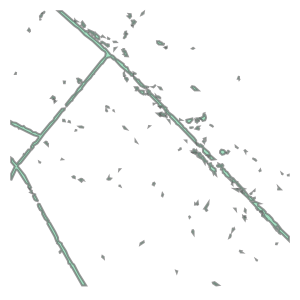

In [218]:
polygons[3]

In [304]:
_p = None
for i, p in enumerate(polygons[3]):
    if len(p.exterior.coords) < 5:
        continue
    _p = p 
    break
p = _p
print i 

1


7


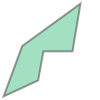

In [229]:
print len(p.exterior.coords)
p

In [231]:
mean = p.exterior.centroid
points = np.array(p.exterior.coords)
e_vecs, e_vals, _ = pca(points)
e_vecs, e_vals

(array([[ 0.67306629,  0.73958216],
        [-0.73958216,  0.67306629]]), array([[ 226.84131759],
        [  21.81174363]]))

In [264]:
from shapely.geometry import Polygon, MultiPolygon, LineString

In [300]:
new_points = []
max_nb_pts = 5
thickness = 15.0
step = 50.0

for i in range(max_nb_pts):
    pt = [mean.x + thickness * e_vecs[1][0] * 0.5, mean.y + thickness * e_vecs[1][1] * 0.5]
    pt[0] += step * i*e_vecs[0][0]
    pt[1] += step * i*e_vecs[0][1]
    new_points.append(pt)
    
for i in range(2*max_nb_pts - 1):
    pt = [mean.x - thickness * e_vecs[1][0] * 0.5, mean.y - thickness * e_vecs[1][1] * 0.5]
    pt[0] += step * (max_nb_pts - i - 1)*e_vecs[0][0]
    pt[1] += step * (max_nb_pts - i - 1)*e_vecs[0][1]    
    new_points.append(pt)

for i in range(max_nb_pts):
    pt = [mean.x + thickness * e_vecs[1][0] * 0.5, mean.y + thickness * e_vecs[1][1] * 0.5]
    pt[0] += step * (i - max_nb_pts + 1)*e_vecs[0][0]
    pt[1] += step * (i - max_nb_pts + 1)*e_vecs[0][1]    
    new_points.append(pt)    


new_polygon = Polygon(new_points)

Self-intersection at or near point 1616.2276409883668 3319.3658459301964


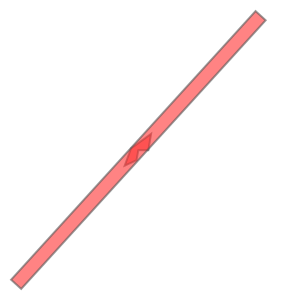

In [301]:
MultiPolygon([p, new_polygon])

In [312]:
poly = polygons[3]
poly.geoms.shape_factory

<bound method MultiPolygon.shape_factory of <shapely.geometry.multipolygon.MultiPolygon object at 0x00000000112BFE48>>

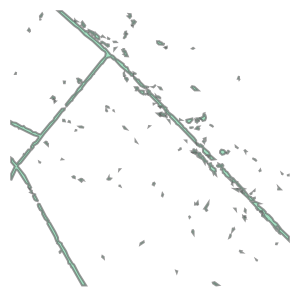

In [308]:
poly[2:]

In [303]:
new_polygon.intersects(poly)

True

In [ ]:
poly

In [ ]:
pt1 = tuple(round_coords(mean)[0])
pt2 = tuple(round_coords(pt1 + 50*e_vecs[0]))
thickness = int(e_vals[1][0]) / 5

In [71]:
np.array(poly.exterior.coords)

array([[ 3259.,  1452.],
       [ 3268.,  1466.],
       [ 3280.,  1467.],
       [ 3271.,  1446.],
       [ 3259.,  1452.]])

In [94]:
def pca(points, n_components=2):
    covar, mean = cv2.calcCovarMatrix(points, None, cv2.COVAR_SCALE | cv2.COVAR_ROWS | cv2.COVAR_SCRAMBLED)
    ret, e_vals, e_vecs = cv2.eigen(covar)
    # Conversion + normalisation required due to 'scrambled' mode
    e_vecs = cv2.gemm(e_vecs, points - mean, 1, None, 0)
    # apply_along_axis() slices 1D rows, but normalize() returns 4x1 vectors
    e_vecs = np.apply_along_axis(lambda n: cv2.normalize(n, None).flat, 1, e_vecs)
    return e_vecs[:n_components,:], e_vals[:n_components,:], mean

In [95]:
pca(np.array(poly.exterior.coords))

(array([[ 0.66803756,  0.74412755],
        [ 0.74412755, -0.66803756]]), array([[ 101.80475081],
        [  31.07524919]]), array([[ 3267.4,  1456.6]]))

In [96]:
round_coords = lambda x: np.array(x).round().astype(np.int32)

In [97]:
pts = np.array(poly.exterior.coords)
pts -= np.array([3200,1400])
pts

array([[ 59.,  52.],
       [ 68.,  66.],
       [ 80.,  67.],
       [ 71.,  46.],
       [ 59.,  52.]])

In [98]:
e_vecs, e_vals, mean = pca(pts)

In [103]:
mean, e_vals, e_vecs

(array([[ 67.4,  56.6]]), array([[ 101.80475081],
        [  31.07524919]]), array([[ 0.66803756,  0.74412755],
        [ 0.74412755, -0.66803756]]))

In [104]:
e_vals[0] > 3 * e_vals[1]

array([ True], dtype=bool)

In [107]:
e_vecs[0]

array([ 0.66803756,  0.74412755])

In [173]:
img = np.zeros((100, 100), dtype=np.uint8)
exterior = [round_coords(pts)]
img = cv2.fillPoly(img, exterior, 255)

In [174]:
from visu_utils import plt_st, display_img_1b

In [183]:
pt1 = tuple(round_coords(mean)[0])
pt2 = tuple(round_coords(pt1 + 50*e_vecs[0]))
thickness = int(e_vals[1][0]) / 5

In [184]:
tuple(pt1), tuple(pt2), thickness

((67, 57), (100, 94), 6)

In [185]:
img2 = cv2.line(img.copy(), pt1, pt2, 127, thickness=thickness)

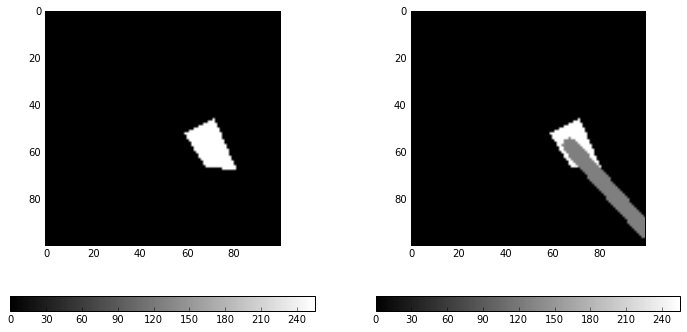

In [186]:
plt_st(12, 6)
plt.subplot(121)
display_img_1b(img)
plt.subplot(122)
display_img_1b(img2)

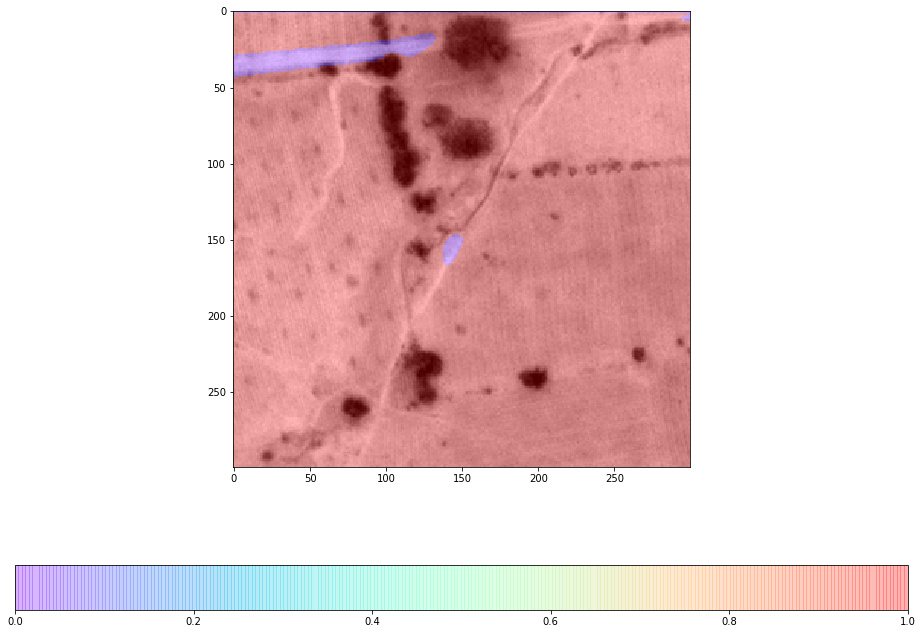

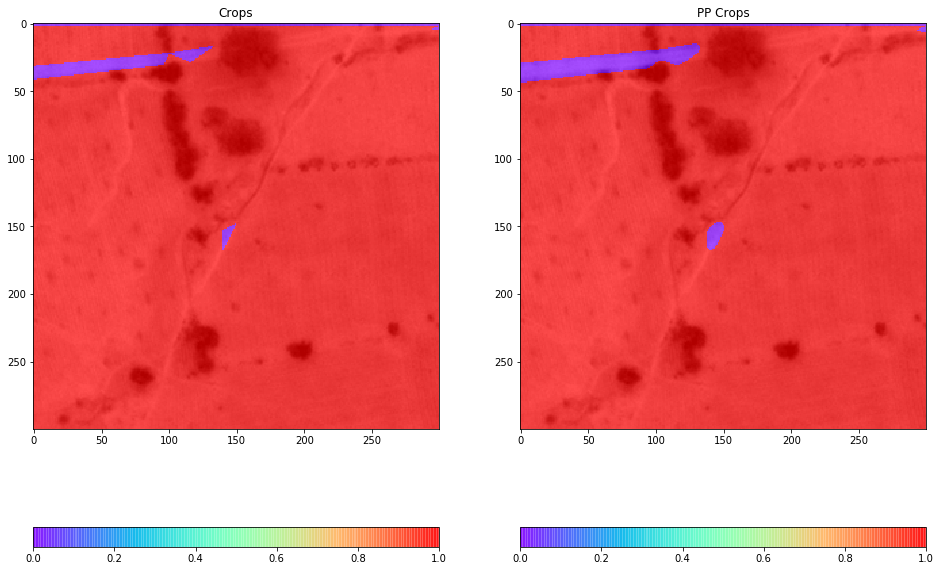

In [25]:
roi = None

# roi = [3000, 0, 3300, 300]
# roi = [0, 1500, 250, 1750]
# roi = [500, 500, 1750, 1750]
# roi = [750, 2750, 1350, 3300]

index = 4
if index in class_pp_func_list:
    bin_img = class_pp_func_list[index](labels_image[:,:,index])
else:
    bin_img = labels_image[:,:,index]

plt_st(16, 12)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(bin_img, roi, alpha=0.3, clim=[0, 1], cmap='rainbow')

plt_st(16, 12)
plt.subplot(121)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(labels_image[:,:,index], roi, alpha=0.7, clim=[0, 1], cmap='rainbow')
plt.title(LABELS[index])
plt.subplot(122)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(bin_img, roi, alpha=0.7, clim=[0, 1], cmap='rainbow')
plt.title("PP " + LABELS[index])

In [26]:
def mask_postprocessing(labels_image, class_pp_func_list):
    out = np.zeros_like(labels_image)
    for i, l in enumerate(LABELS):
        if i in class_pp_func_list:
            out[:,:,i] = class_pp_func_list[i](labels_image[:,:,i])
        else:
            out[:,:,i] = labels_image[:,:,i]
    return out

In [27]:
from data_utils import mask_to_polygons

def write_shp_from_mask(filename, image_id, labels_image):
    all_scaled_polygons = {}
    for class_index in range(1, len(LABELS[1:])):
        polygons = mask_to_polygons(labels_image[:, :, class_index])
        all_scaled_polygons[class_index] = polygons
    write_shp_from_polygons(filename, image_id, all_scaled_polygons)    

In [465]:
pp_labels_image = mask_postprocessing(labels_image, class_pp_func_list)

In [466]:
write_shp_from_mask("%s_pp.shp" % image_id, image_id, pp_labels_image)

Self-intersection at or near point 2488.7408312958437 2092.7530562347188


Written succesfully file :  6120_2_1_pp.shp


In [18]:
for class_index in range(1, len(LABELS)):
    print class_index

1
2
3
4
5
6
7
8
9
10


ML for ROADS

In [15]:
from data_utils import get_resized_polygons

In [16]:
round_coords = lambda x: np.array(x).round().astype(np.int32)

def compute_features(p):
    cnt = round_coords(p.exterior.coords)
    defects = cv2.convexityDefects(cnt,cv2.convexHull(cnt, returnPoints=False))
    p2 = p.convex_hull
    ha = p2.area
    hl = p2.length
    dims = (p.length, p.area)
    indices = (4.0 * np.pi * p.area / p.length ** 2, p.area/p.length)    
    indices2 = (ha/p.area, 
                p.length/hl, 
                p.area/hl, 
                ha/p.length,
                p.area/hl**2, 
                ha/p.length**2,
                ha - p.area,
                p.length - hl)
    moments = cv2.moments(cnt)
    hu_moments = cv2.HuMoments(moments)
    if defects is not None:
        defs = (np.min(defects[:,0,-1]), np.max(defects[:,0,-1]), np.mean(defects[:,0,-1]))
    else:
        defs = (0,0,0)
    return dims + indices + indices2 + defs + tuple(hu_moments.ravel().tolist())

In [17]:
index = 3
road_properties = []
road_target_labels = []
for data_csv in submission_iterator(CSV_FILE_TRAIN):
    image_id = data_csv[0][0]
    print "--", image_id
    image_height, image_width, _ = get_image_data(image_id, '3b', return_shape_only=True)
    truth_polygons = get_resized_polygons(image_id, image_height, image_width, classes=[index])
    
    polygons = get_scaled_polygons(data_csv)
    if index not in polygons:
        continue
        
    for p in polygons[index]:        
        road_properties.append(compute_features(p))
        road_target_labels.append(p.intersects(truth_polygons[index]))    
road_properties = np.array(road_properties)
road_target_labels = np.array(road_target_labels)

-- 6040_2_2
-- 6120_2_2
-- 6120_2_0
-- 6090_2_0
-- 6040_1_3
-- 6040_1_0
-- 6100_1_3
-- 6010_4_2
-- 6110_4_0
-- 6140_3_1
-- 6110_1_2
-- 6100_2_3
-- 6150_2_3
-- 6160_2_1
-- 6140_1_2
-- 6110_3_1
-- 6010_4_4
-- 6170_2_4
-- 6170_4_1
-- 6170_0_4
-- 6060_2_3
-- 6070_2_3
-- 6010_1_2
-- 6040_4_4
-- 6100_2_2


In [414]:
road_properties.shape, road_target_labels.shape

((944, 22), (944,))

In [31]:
import cPickle
with open('weights/roads_form_classifier', 'rb') as f:
    roads_classifier = cPickle.load(f)

In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score

In [416]:
# def normalize(properties):
#     return (properties - np.mean(properties, axis=0)) / (np.std(properties, axis=0) + 1e-10)

In [417]:
gbc = GradientBoostingClassifier()
rf = RandomForestClassifier()

n_folds = 5
params_gbc = {
    'n_estimators': range(100, 200, 5),
    'max_depth': range(2,5)
}
params_rf = {
    'n_estimators': range(10, 50, 5),
    'max_depth': range(2,10)
}

In [418]:
# print("Best parameters set found on development set: \n {} \n".format(clf.best_params_))
# print("Grid scores on development set: \n")
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# param_res = clf.cv_results_['params']
# for mean, std, params in zip(means, stds, param_res):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))

In [419]:
x_train, x_test, y_train, y_test = train_test_split(road_properties, road_target_labels, train_size=0.7)

In [420]:
for name, _clf, params, constructor in zip(["gbc", "rf"], 
                              [gbc, rf], 
                              [params_gbc, params_rf], 
                              [GradientBoostingClassifier, RandomForestClassifier]):
    print "\n-- Classifier : ", name
    clf = GridSearchCV(_clf, params, scoring='roc_auc', cv=n_folds)
    _ = clf.fit(road_properties, road_target_labels)
    _clf = constructor(**clf.best_params_)
    _clf.fit(x_train, y_train)
    y_pred = _clf.predict(x_train)
    print "Train precision, recall: ", precision_score(y_train, y_pred), recall_score(y_train, y_pred)
    y_pred = _clf.predict(x_test)
    print "Test precision, recall: ", precision_score(y_test, y_pred), recall_score(y_test, y_pred)


-- Classifier :  gbc
Train precision, recall:  1.0 1.0
Test precision, recall:  0.85 0.485714285714

-- Classifier :  rf
Train precision, recall:  1.0 0.650602409639
Test precision, recall:  0.928571428571 0.371428571429


In [33]:
# clf = gbc
clf = roads_classifier

In [21]:
clf.fit(road_properties, road_target_labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [34]:
clf.feature_importances_

array([ 0.09222077,  0.09358902,  0.04244718,  0.03508026,  0.02576658,
        0.0236142 ,  0.01621735,  0.06992042,  0.05252536,  0.08843544,
        0.01460265,  0.0058456 ,  0.04137718,  0.01547549,  0.0154461 ,
        0.07451157,  0.05704315,  0.06134837,  0.02704374,  0.01941029,
        0.05231141,  0.07576788])

In [42]:
# image_id = "6110_1_1"
# image_id = "6110_1_0"
# image_id = "6120_3_1"
# image_id = "6120_3_2"
image_id = "6110_3_0"
image_id = "6110_2_2"
data_csv = get_data_csv(image_id, CSV_FILE_NEW)


# image_id = "6120_2_2"
# image_id = "6100_1_3"
# image_id = "6140_3_1"
# data_csv = get_data_csv(image_id, CSV_FILE_TRAIN)

assert data_csv is not None, "WTF"
polygons = get_scaled_polygons(data_csv)

In [43]:
from shapely.geometry import MultiPolygon

In [44]:
index = 3
road_properties = []
for i, p in enumerate(polygons[index]):    
    road_properties.append(compute_features(p))
road_properties = np.array(road_properties)        


In [45]:
road_target_labels = clf.predict(road_properties)

In [46]:
# for prs, v in zip(road_target_labels_probas, road_target_labels):
#     print prs, v

3 23


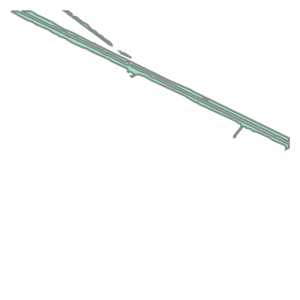

In [47]:

road_properties = []
for i, p in enumerate(polygons[index]):    
    road_properties.append(compute_features(p))
road_properties = np.array(road_properties)        
road_target_labels = clf.predict(road_properties)

new_polygons = []   
for i, p in enumerate(polygons[index]):
    if road_target_labels[i]:
        new_polygons.append(p)
    
    
new_polygons = MultiPolygon(new_polygons)
print len(new_polygons), len(polygons[3])
new_polygons

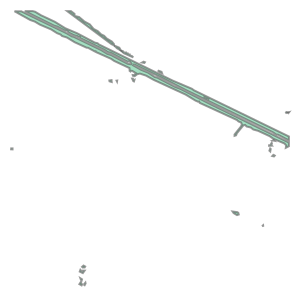

In [48]:
polygons[3]

In [49]:
from postprocessing_utils import roads_shape_postprocessing

In [50]:
out = roads_shape_postprocessing(polygons[3])

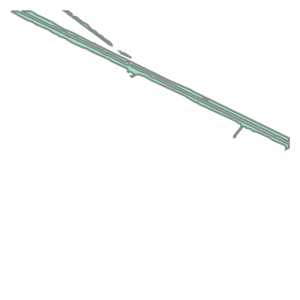

In [51]:
out

In [436]:
import cPickle

with open('weights/roads_form_classifier', 'wb') as f:
    cPickle.dump(clf, f)

In [63]:
image_id = "6030_5_4"

In [64]:
"6050" in image_id and (image_id != "6050_4_4" and image_id !="6050_4_3")

False